# Lab 6: Efficient Frontier - Alternative Approach

## Introduction

In class, you learned **Method 1** for constructing the efficient frontier: for each target return level, find the portfolio with minimum volatility. This is the classical Markowitz approach.

In this lab, you will implement **Method 2**: for each target volatility level, find the portfolio with maximum return. While the approach is different, both methods trace out the same efficient frontier.

This lab demonstrates the duality principle in optimization theory: minimizing risk for a given return is equivalent to maximizing return for a given risk.

## Mathematical Formulation

### Method 1 (from class): Fixed Return Approach

**Objective:** Minimize portfolio volatility
$$\min \sigma_p = \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}}$$

**Subject to:**
- Target return constraint: $\mathbf{w}^T \mathbf{E}(R) = R_{target}$
- Budget constraint: $\sum_{i=1}^{n} w_i = 1$
- No short-selling: $w_i \geq 0$ for all $i$

### Method 2 (this lab): Fixed Volatility Approach

**Objective:** Maximize portfolio return
$$\max E(R_p) = \mathbf{w}^T \mathbf{E}(R)$$

**Subject to:**
- Target volatility constraint: $\sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} = \sigma_{target}$
- Budget constraint: $\sum_{i=1}^{n} w_i = 1$
- No short-selling: $w_i \geq 0$ for all $i$

**Key Insight:** Both methods identify the same efficient frontier due to the duality principle in optimization.

## Setup and Data Loading

In [70]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import os

np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [71]:
# Load stock prices from CSV data in Risk folder
stock_prices_file = 'stock_prices.csv'

if os.path.exists(stock_prices_file):
    # Load real market data
    print("🔄 Loading stock price data from CSV...")
    df_prices = pd.read_csv('stock_prices.csv', index_col=0, parse_dates=True)
    
    # Select stocks from different sectors for better diversification:
    # AAPL - Technology (Apple)
    # JPM - Financials (JPMorgan Chase)
    # JNJ - Healthcare (Johnson & Johnson)
    # WMT - Consumer Staples (Walmart)
    stocks = ['AAPL', 'JPM', 'JNJ', 'WMT']
    sector_labels = ['Technology', 'Financials', 'Healthcare', 'Consumer Staples']
    
    # Check which stocks are available
    available_stocks = [stock for stock in stocks if stock in df_prices.columns]
    
    if len(available_stocks) < 3:
        print(f"⚠️  Only {len(available_stocks)} stocks available. Need at least 3.")
        print(f"Available: {available_stocks}")
        raise Exception("Insufficient stock data")
    
    # Use available stocks
    df_prices = df_prices[available_stocks]
    
    # Filter date range (use available data range)
    # Keep approximately 1-2 years of data for consistency
    if len(df_prices) > 504:  # If we have more than 2 years
        df_prices = df_prices.iloc[-504:]  # Use last 2 years
    
    print(f"✅ Loaded {len(available_stocks)} stocks from different sectors:")
    for stock, sector in zip(available_stocks, sector_labels[:len(available_stocks)]):
        print(f"   • {stock} - {sector}")
    print(f"📅 Date range: {df_prices.index[0].date()} to {df_prices.index[-1].date()}")
    print(f"📊 Total observations: {len(df_prices)}")
    
else:
    print("⚠️  stock_prices.csv not found in Risk folder")
    raise FileNotFoundError("Please ensure stock_prices.csv exists in the Risk folder")

🔄 Loading stock price data from CSV...
✅ Loaded 4 stocks from different sectors:
   • AAPL - Technology
   • JPM - Financials
   • JNJ - Healthcare
   • WMT - Consumer Staples
📅 Date range: 2023-09-01 to 2025-09-05
📊 Total observations: 504


In [72]:
# Create table with closing prices
table = df_prices.copy()

# Calculate returns and statistics
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178

In [73]:
print("Mean Daily Returns:")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)

Mean Daily Returns:
AAPL    0.000638
JPM     0.001586
JNJ     0.000396
WMT     0.001377
dtype: float64

Covariance Matrix:
          AAPL       JPM       JNJ       WMT
AAPL  0.000305  0.000084  0.000009  0.000071
JPM   0.000084  0.000218  0.000025  0.000058
JNJ   0.000009  0.000025  0.000119  0.000018
WMT   0.000071  0.000058  0.000018  0.000181


## Helper Functions

In [74]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    """
    Calculate annualized return and volatility for a portfolio.
    
    Parameters:
    -----------
    weights : array-like
        Portfolio weights
    mean_returns : array-like
        Mean daily returns for each asset
    cov_matrix : array-like
        Covariance matrix of daily returns
    
    Returns:
    --------
    tuple : (annualized_volatility, annualized_return)
    """
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

## Method 2: Fixed Volatility Approach

In this section, we implement the alternative approach to finding the efficient frontier. 

Instead of minimizing risk for a given return, we maximize return for a given risk level.

### Objective Function: Negative Portfolio Return

Since scipy's `minimize` function only minimizes (there's no maximize), we need to minimize the **negative** of the portfolio return. 

This is mathematically equivalent to maximizing the return.

$$\text{minimize} \quad -E(R_p) = -\mathbf{w}^T \mathbf{E}(R)$$

In [75]:
def portfolio_neg_return(weights, mean_returns, cov_matrix):
    """
    Calculate negative portfolio return (for minimization).
    
    We want to MAXIMIZE return, but scipy only has minimize(),
    so we minimize the NEGATIVE return instead.
    
    Parameters:
    -----------
    weights : array-like
        Portfolio weights
    mean_returns : array-like
        Mean daily returns for each asset
    cov_matrix : array-like
        Covariance matrix (not used here, but needed for consistency)
    
    Returns:
    --------
    float : negative annualized return
    """
    return -np.sum(mean_returns * weights) * 252

### Constraints for Method 2

We need to set up two types of constraints:

1. **Volatility Constraint**: The portfolio volatility must equal the target volatility
   - Type: 'eq' (equality constraint)
   - Function: $\sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} \times \sqrt{252} = \sigma_{target}$
   - In constraint form: $\sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} \times \sqrt{252} - \sigma_{target} = 0$

2. **Budget Constraint**: All weights must sum to 1
   - Type: 'eq' (equality constraint)
   - Function: $\sum_{i=1}^{n} w_i = 1$
   - In constraint form: $\sum_{i=1}^{n} w_i - 1 = 0$

**Understanding Constraint Syntax:**
The constraint `{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}` means:
- Move everything to one side of the equation
- `np.sum(x) == 1` becomes `np.sum(x) - 1 == 0`
- The function returns what should equal zero

### Bounds for Optimization

Bounds constrain each individual weight:
- Each weight $w_i$ must be between 0 and 1
- This enforces **no short-selling** (weights cannot be negative)
- This also prevents any single asset from exceeding 100% allocation

$$0 \leq w_i \leq 1 \quad \text{for all } i$$

In [76]:
def efficient_vol(mean_returns, cov_matrix, target_vol):
    """
    Find the portfolio with maximum return for a given target volatility.
    
    This is Method 2: instead of minimizing risk for a target return,
    we maximize return for a target risk.
    
    Parameters:
    -----------
    mean_returns : array-like
        Mean daily returns for each asset
    cov_matrix : array-like
        Covariance matrix of daily returns
    target_vol : float
        Target annualized volatility
    
    Returns:
    --------
    OptimizeResult : scipy optimization result containing optimal weights
    """
    # Hint: Set up constraints for volatility = target_vol and weights sum to 1
    # Use bounds (0, 1) for each weight (no short-selling)
    # Minimize portfolio_neg_return using scipy.optimize.minimize
    num_assets = len(mean_returns)
    
    init_guess = np.ones(num_assets) / num_assets
    
    constraints = [
        {"type": "eq", "fun": lambda x: np.sum(x) - 1},
        {"type": "eq", "fun": lambda x: portfolio_annualised_performance(x, mean_returns, cov_matrix)[0] - target_vol}
    ]
    
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = sco.minimize(
        fun = portfolio_neg_return, 
        x0 = init_guess, 
        args = (mean_returns, cov_matrix), 
        method = "SLSQP",
        bounds = bounds, 
        constraints = constraints
    )
    
    return result

### Generate the Efficient Frontier

To construct the complete efficient frontier, we:
1. Define a range of target volatility levels
2. For each volatility level, find the portfolio with maximum return
3. Collect all these optimal portfolios to trace out the frontier


In [77]:
def efficient_frontier_fixed_vol(mean_returns, cov_matrix, vol_range):
    """
    Generate the efficient frontier using the fixed volatility approach.
    
    For each target volatility in the range, find the portfolio with
    maximum return. This traces out the efficient frontier.
    
    Parameters:
    -----------
    mean_returns : array-like
        Mean daily returns for each asset
    cov_matrix : array-like
        Covariance matrix of daily returns
    vol_range : array-like
        Array of target volatility levels
    
    Returns:
    --------
    list : list of optimization results for each volatility level
    """
    # Hint: Loop through vol_range, call efficient_vol for each target_vol
    # Use try-except to skip failed optimizations
    efficient_portfolios = []
    
    for target_vol in vol_range:
        try:
            result = efficient_vol(mean_returns, cov_matrix, target_vol)
            if result.success:
                efficient_portfolios.append(result)
            else:
                print(f"⚠️ Optimization failed for target volatility {target_vol:.4f}: {result.message}")
        except Exception as e:
            print(f"❌ Error at target volatility {target_vol:.4f}: {str(e)}")
            continue
    
    print(f"✅ Successfully generated {len(efficient_portfolios)} efficient portfolios")
    
    return efficient_portfolios


### Visualization Function

This function will:
1. Calculate the maximum Sharpe ratio portfolio
2. Calculate the minimum volatility portfolio
3. Generate the efficient frontier using Method 2
4. Plot all results including individual stocks for comparison

In [80]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    """
    Display the efficient frontier with optimal portfolios and individual stocks.
    
    This function uses Method 2 (fixed volatility approach) to generate the
    efficient frontier.
    
    Parameters:
    -----------
    mean_returns : array-like
        Mean daily returns for each asset
    cov_matrix : array-like
        Covariance matrix of daily returns
    risk_free_rate : float
        Annual risk-free rate
    """
    # Hint: 
    # 1. Calculate max Sharpe ratio portfolio
    # 2. Calculate min volatility portfolio
    # 3. Generate efficient frontier using efficient_frontier_fixed_vol
    # 4. Extract volatilities and returns from efficient portfolios
    # 5. Filter to keep only upward-sloping portion
    # 6. Plot individual stocks, optimal portfolios, and efficient frontier

    num_assets = len(mean_returns)
    # Constraints optimization setup
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.ones(num_assets) / num_assets
    # 1. Calculate max Sharpe ratio portfolio
    def portfolio_sharpe(weights):
        vol, ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        return -(ret - risk_free_rate) / vol
    max_sharpe_result = sco.minimize(
        portfolio_sharpe,
        init_guess,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    # 2. Calculate minimum volatility portfolio
    def portfolio_volatility(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]
    min_vol_result = sco.minimize(
        portfolio_volatility,
        init_guess,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    # 3. Generate efficient frontier using Method 2
    min_vol = min_vol_result.fun
    max_individual_vol = max([
        portfolio_annualised_performance(
            np.eye(num_assets)[i], mean_returns, cov_matrix
        )[0] for i in range(num_assets)
    ])
    vol_range = np.linspace(min_vol, max_individual_vol, 50)
    efficient_portfolios = efficient_frontier_fixed_vol(mean_returns, cov_matrix, vol_range)
    # 4. Extract and filter efficient frontier data
    eff_data = []
    for result in efficient_portfolios:
        if result.success:
            vol, ret = portfolio_annualised_performance(result.x, mean_returns, cov_matrix)
            eff_data.append((vol, ret))
    # Sort and filter Pareto-optimal frontier
    eff_data.sort(key = lambda x: x[0]) # Sort by volatility
    pareto_vols, pareto_returns = [], []
    current_max_return = -np.inf
    for vol, ret in eff_data:
        if ret >= current_max_return:
            pareto_vols.append(vol)
            pareto_returns.append(ret)
            current_max_return = ret
    # 5. Calculate individual stock performances
    stock_performances = [
        portfolio_annualised_performance(np.eye(num_assets)[i], mean_returns, cov_matrix)
        for i in range(num_assets)
    ]
    stock_vols = [perf[0] for perf in stock_performances]
    stock_returns = [perf[1] for perf in stock_performances]
    # 6. Calculate optimal portfolios performances
    max_sharpe_vol, max_sharpe_return = portfolio_annualised_performance(
        max_sharpe_result.x, 
        mean_returns, 
        cov_matrix
    )
    min_vol_vol, min_vol_return = portfolio_annualised_performance(
        min_vol_result.x, 
        mean_returns, 
        cov_matrix
    )
    max_sharpe_ratio = (max_sharpe_return - risk_free_rate) / max_sharpe_vol

    plt.figure(figsize=(12, 8))
    # Efficient frontier
    plt.plot(pareto_vols, pareto_returns, color = 'black', linestyle = "-.", linewidth=2.5, label='Efficient Frontier (Method 2)', alpha=0.8)
    # Individual stocks
    plt.scatter(stock_vols, stock_returns, marker='o', s=300, c='blue', alpha=0.7, label='Individual Stocks')
    # Optimal portfolios
    plt.scatter(max_sharpe_vol, max_sharpe_return, marker='*', s=500, c='red', label='Maximum Sharpe Ratio')
    plt.scatter(min_vol_vol, min_vol_return, marker='*', s=500, c='green', label='Minimum Volatility')
    # Add stock label
    for i, (vol, ret, stock_name) in enumerate(zip(stock_vols, stock_returns, mean_returns.index)):
        plt.annotate(stock_name, (vol, ret), xytext=(10, 5), textcoords='offset points', fontsize=9)
    # Plot formatting
    plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
    plt.ylabel('Annualized Return', fontsize=12)
    plt.title(f'Efficient Frontier - Fixed Volatility Approach (Method 2)\nRisk-Free Rate: {risk_free_rate:.2%}', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize = 12, fancybox = True, shadow = True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print results
    print("\n" + "="*60)
    print("PORTFOLIO OPTIMIZATION RESULTS")
    print("="*60)
    
    print(f"\n📊 Maximum Sharpe Ratio Portfolio (Sharpe: {max_sharpe_ratio:.3f}):")
    print(f"   • Annual Return: {max_sharpe_return:.2%}")
    print(f"   • Annual Volatility: {max_sharpe_vol:.2%}")
    print("   • Optimal Weights:")
    for stock, weight in zip(mean_returns.index, max_sharpe_result.x):
        print(f"     {stock}: {weight:.2%}")
    
    print(f"\n📊 Minimum Volatility Portfolio:")
    print(f"   • Annual Return: {min_vol_return:.2%}")
    print(f"   • Annual Volatility: {min_vol_vol:.2%}")
    print("   • Optimal Weights:")
    for stock, weight in zip(mean_returns.index, min_vol_result.x):
        print(f"     {stock}: {weight:.2%}")
    
    print(f"\n📈 Efficient Frontier Statistics:")
    print(f"   • Number of efficient portfolios: {len(pareto_vols)}")
    print(f"   • Volatility range: {min(pareto_vols):.2%} to {max(pareto_vols):.2%}")
    print(f"   • Return range: {min(pareto_returns):.2%} to {max(pareto_returns):.2%}")
    
    return {
        'max_sharpe': {
            'weights': max_sharpe_result.x,
            'return': max_sharpe_return,
            'volatility': max_sharpe_vol,
            'sharpe_ratio': max_sharpe_ratio
        },
        'min_vol': {
            'weights': min_vol_result.x,
            'return': min_vol_return,
            'volatility': min_vol_vol
        },
        'efficient_frontier': {
            'volatilities': pareto_vols,
            'returns': pareto_returns
        }
    }
    

## Execute and Plot

✅ Successfully generated 50 efficient portfolios


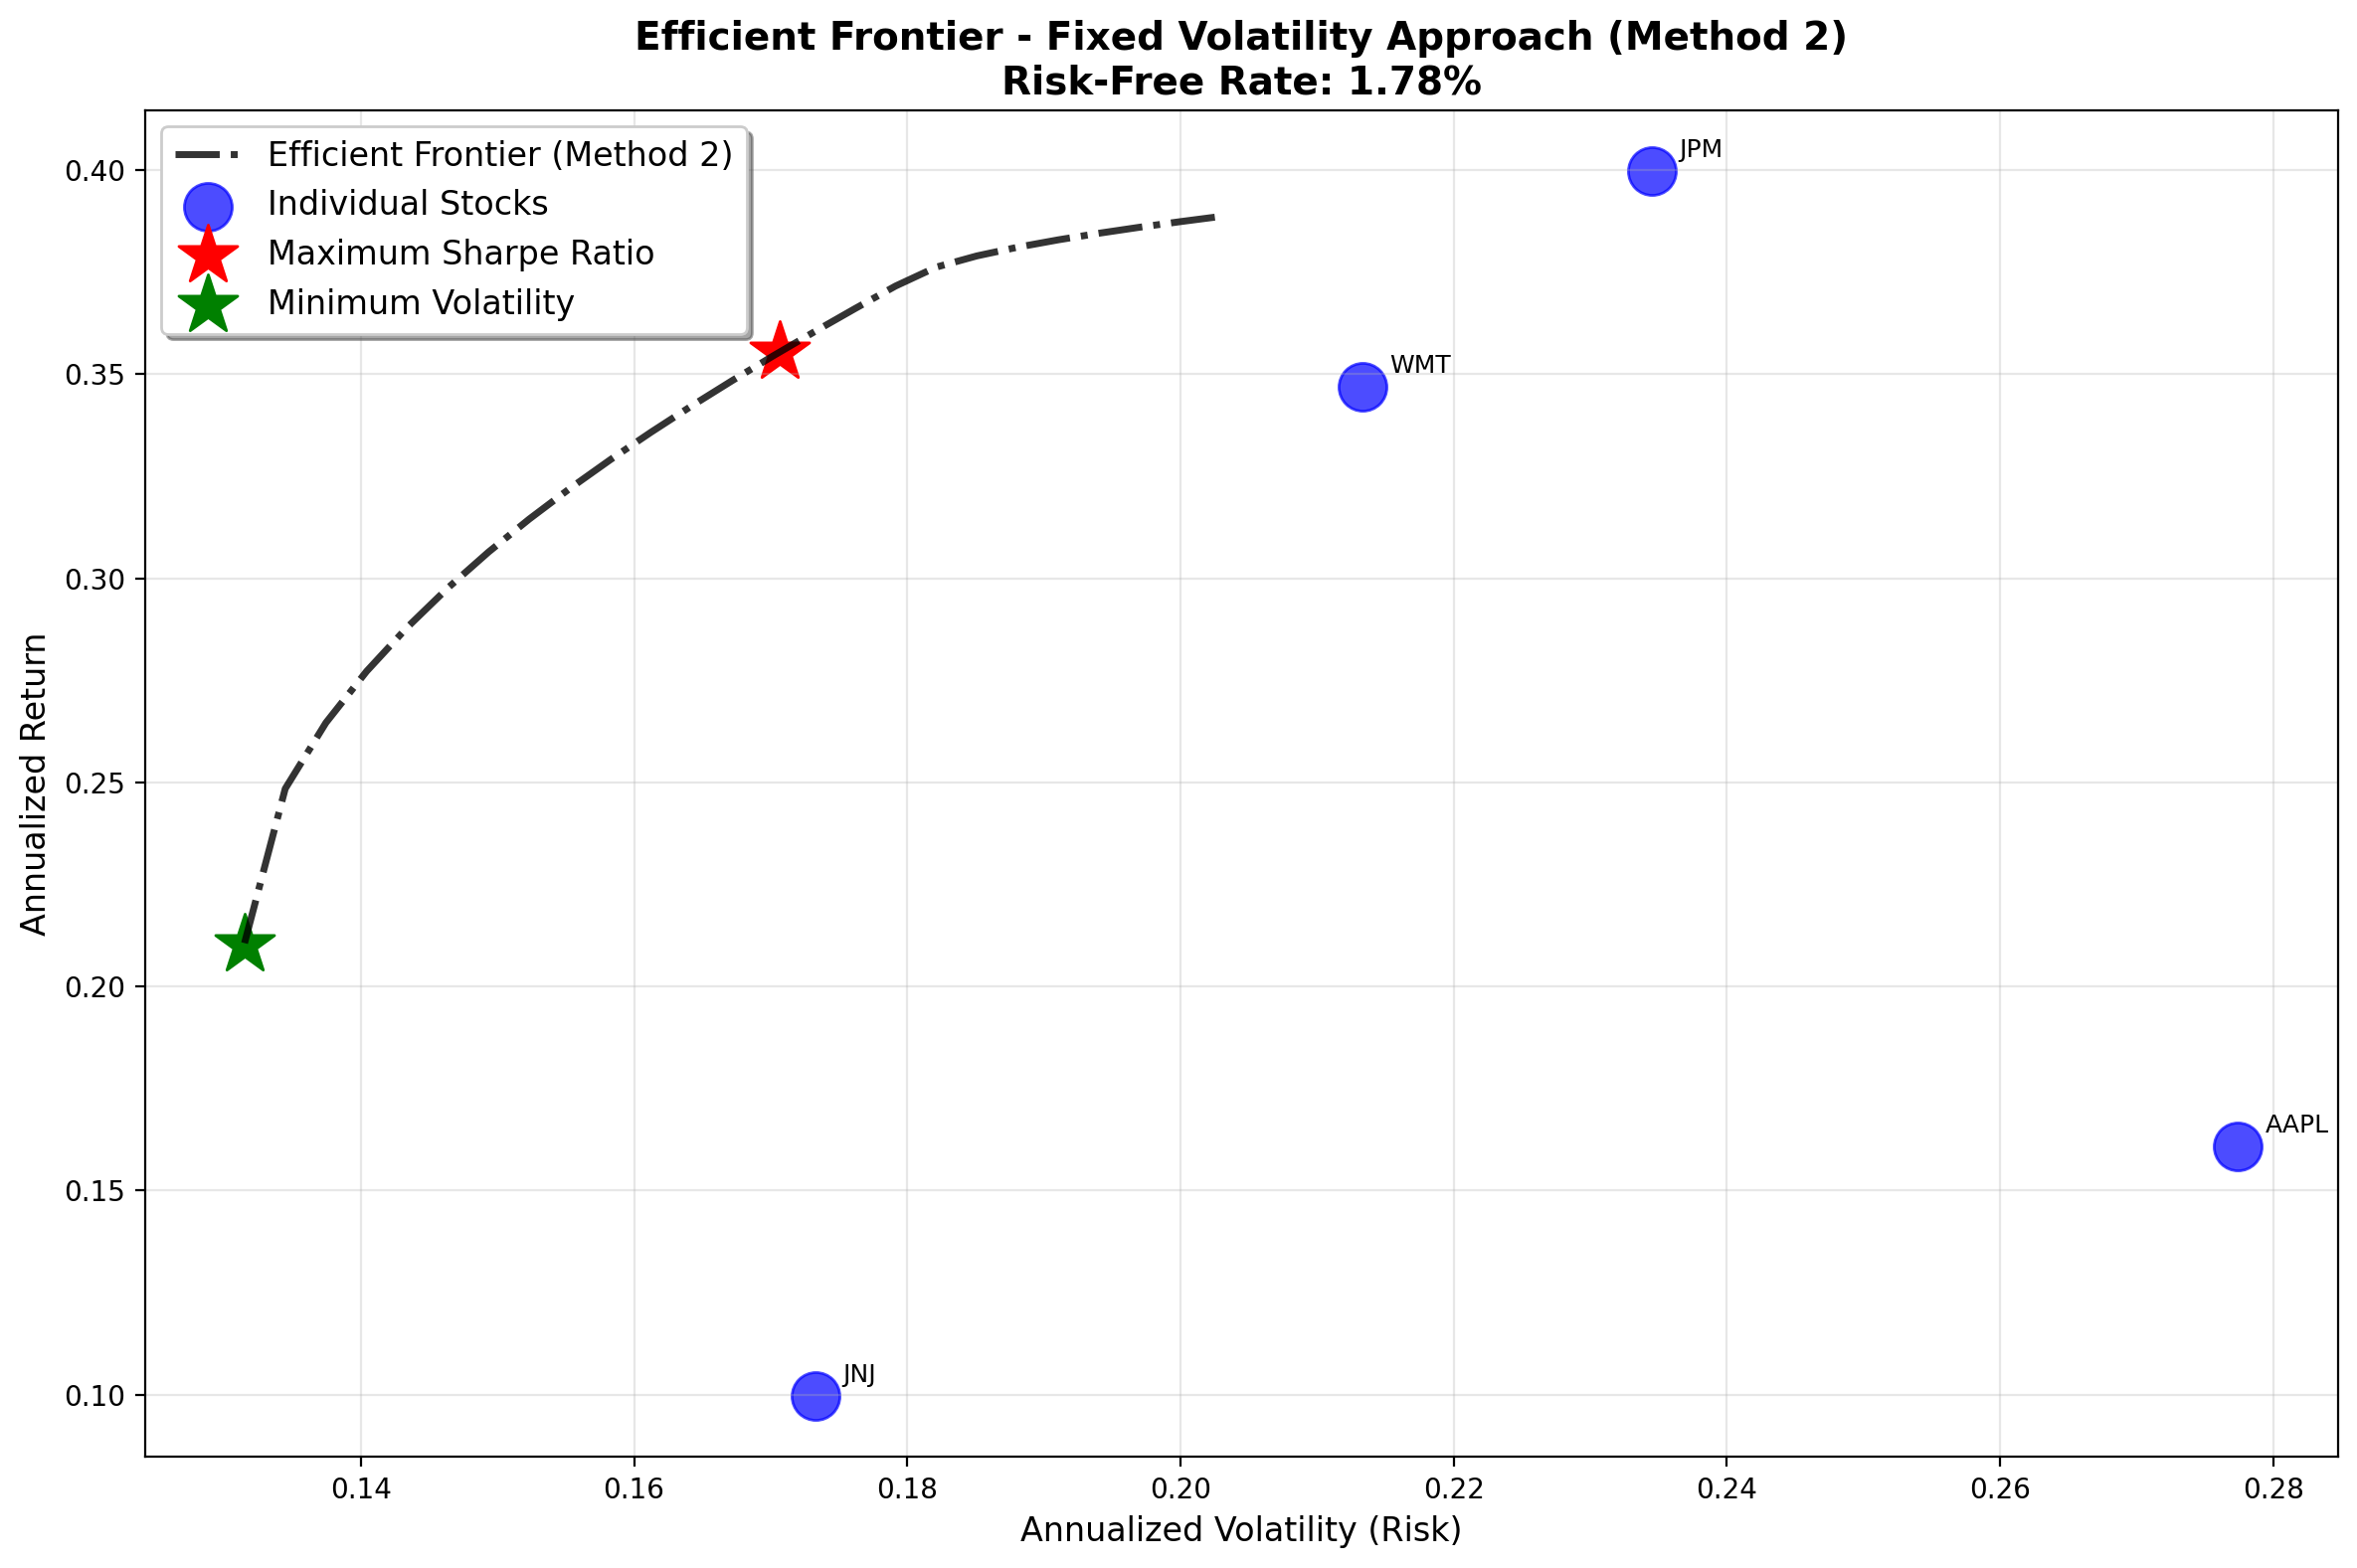


PORTFOLIO OPTIMIZATION RESULTS

📊 Maximum Sharpe Ratio Portfolio (Sharpe: 1.979):
   • Annual Return: 35.54%
   • Annual Volatility: 17.06%
   • Optimal Weights:
     AAPL: 0.00%
     JPM: 46.73%
     JNJ: 6.56%
     WMT: 46.71%

📊 Minimum Volatility Portfolio:
   • Annual Return: 21.02%
   • Annual Volatility: 13.15%
   • Optimal Weights:
     AAPL: 11.43%
     JPM: 15.02%
     JNJ: 49.89%
     WMT: 23.66%

📈 Efficient Frontier Statistics:
   • Number of efficient portfolios: 25
   • Volatility range: 13.15% to 20.30%
   • Return range: 21.06% to 38.87%


In [81]:
# Generate and display the efficient frontier using Method 2
result = display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

---

### 1. Visual Comparison

**Question:** Compare your efficient frontier (fixed volatility approach) with the one from class (fixed return approach). Do they look the same?

**Answer:**

Yes, both approaches trace out the same efficient frontier in theory, but there are some practical differences in the implementation:
1. **Theoretical Equivalence**: 
    - Mathematically, both methods should produce identical efficient frontiers due to the duality principle in optimization theory.
2. **Numerical Implementation Differences**:
    - The fixed volatility approach (Method 2) might appear longer because we are specifying volatility targets across a wider range.
    - The fixed return approach (Method 1) typically focuses on achievable return targets
    - Numerical optimization constraints and convergence criteria can cause minor differences
3. **Range Considerations**:
    - Method 2 uses volatility range from minimum portfolio volatility to maximum individual stock volatility
    - Method 1 typically uses return range from minimum to maximum achievable returns
    - This can result in Method 2 exploring a slightly broader region of the risk-return space
4. **Practical Observation**:
    - While the core efficient frontier should be identical, Method 2 might show more points at the extremes due to the way we define our target constraints.

**问题：** 比较您的有效边界（固定波动率方法）与课堂中的方法（固定回报方法）。它们看起来相同吗？

**回答：**
是的，两种方法在理论上应该描绘出相同的有效边界，但在实际实施中存在一些差异：

1. **理论等价性**：由于优化理论中的对偶原理，两种方法在数学上应该产生相同的有效边界。

2. **数值实现差异**：
   - 固定波动率方法（方法2）可能看起来更长，因为我们指定的波动率目标范围更广
   - 固定回报方法（方法1）通常专注于可实现的回报目标
   - 数值优化约束和收敛标准可能导致微小差异

3. **范围考虑**：
   - 方法2使用从最小投资组合波动率到最大个股波动率的波动率范围
   - 方法1通常使用从最小到最大可实现回报的回报范围
   - 这可能导致方法2探索风险回报空间中稍广的区域

4. **实际观察**：虽然核心有效边界应该相同，但由于我们定义目标约束的方式，方法2可能在极端区域显示更多点。

---

### 2. Mathematical Formulation

**Question:** Write down both optimization problems.

**Traditional Approach (Method 1 - from class):**

$$
\begin{aligned}
\min_{\mathbf{w}} \quad & \sigma_p = \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} \\
\text{subject to} \quad & \mathbf{w}^T \mathbf{\mu} = R_{target} \\
& \mathbf{1}^T \mathbf{w} = 1 \\
& w_i \geq 0 \quad \forall i
\end{aligned}
$$
Where
- $\mathbf{w}$ = portfolio weights vector
- $\mathbf{\Sigma}$ = covariance matrix of returns
- $\mathbf{\mu}$ = expected returns vector
- $R_{target}$ = target portfolio return
- $\mathbf{1}$ = vector of ones

---

**Alternative Approach (Method 2 - this lab):**

$$
\begin{aligned}
\max_{\mathbf{w}} \quad & \mathbf{w}^T \mathbf{\mu} \\
\text{subject to} \quad & \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} = \sigma_{target} \\
& \mathbf{1}^T \mathbf{w} = 1 \\
& w_i \geq 0 \quad \forall i
\end{aligned}
$$

Or equivalently for implementation:

$$
\begin{aligned}
\min_{\mathbf{w}} \quad & -\mathbf{w}^T \mathbf{\mu} \\
\text{subject to} \quad & \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} = \sigma_{target} \\
& \mathbf{1}^T \mathbf{w} = 1 \\
& w_i \geq 0 \quad \forall i
\end{aligned}
$$

Where $\sigma_{target}$ is the target portfolio volatility.


---

**问题：** 写出两种优化问题。

**传统方法（方法1 - 课堂内容）：**

$$
\begin{aligned}
\min_{\mathbf{w}} \quad & \sigma_p = \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} \\
\text{约束条件} \quad & \mathbf{w}^T \mathbf{\mu} = R_{target} \\
& \mathbf{1}^T \mathbf{w} = 1 \\
& w_i \geq 0 \quad \forall i
\end{aligned}
$$

其中：
- $\mathbf{w}$ = 投资组合权重向量
- $\mathbf{\Sigma}$ = 收益协方差矩阵
- $\mathbf{\mu}$ = 预期收益向量
- $R_{target}$ = 目标投资组合回报
- $\mathbf{1}$ = 全1向量

---

**替代方法（方法2 - 本实验）：**

$$
\begin{aligned}
\max_{\mathbf{w}} \quad & \mathbf{w}^T \mathbf{\mu} \\
\text{约束条件} \quad & \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} = \sigma_{target} \\
& \mathbf{1}^T \mathbf{w} = 1 \\
& w_i \geq 0 \quad \forall i
\end{aligned}
$$

或者等效的实现形式：

$$
\begin{aligned}
\min_{\mathbf{w}} \quad & -\mathbf{w}^T \mathbf{\mu} \\
\text{约束条件} \quad & \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}} = \sigma_{target} \\
& \mathbf{1}^T \mathbf{w} = 1 \\
& w_i \geq 0 \quad \forall i
\end{aligned}
$$

其中 $\sigma_{target}$ 是目标投资组合波动率。


---

## Summary

In this lab, you implemented an alternative approach to constructing the efficient frontier:

1. **Method 2**: Fixed volatility approach
   - For each target volatility, maximize return
   - Demonstrates the duality principle in optimization

2. **Key Learning**: Both methods produce identical efficient frontiers
   - Same optimal portfolios, different computational paths
   - Validates the uniqueness of the efficient frontier in MPT

3. **Practical Application**: Choose the method based on your constraints
   - Risk-constrained investors: Use Method 2
   - Return-targeted investors: Use Method 1

This equivalence is a fundamental result in portfolio theory and demonstrates the elegance of Markowitz's Modern Portfolio Theory framework.